# Question 2: Plot
Plot a histogram of the processed amounts of each transaction, the transactionAmount column.

Report any structure you find and any hypotheses you have about that structure.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
df = pd.read_csv('transactions.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  int64  
 10  posConditionCode          786363 non-null  int64  
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

## Histograms of transaction amount

I show here 3 histograms of transaction amount. Top figure is a histogram for overall transaction amount, the second figure (in blue) shows fraudulent transactions, and the third (in red) shows normal transaction amount distribution. 

Text(0.5, 0, 'Transaction Amount')

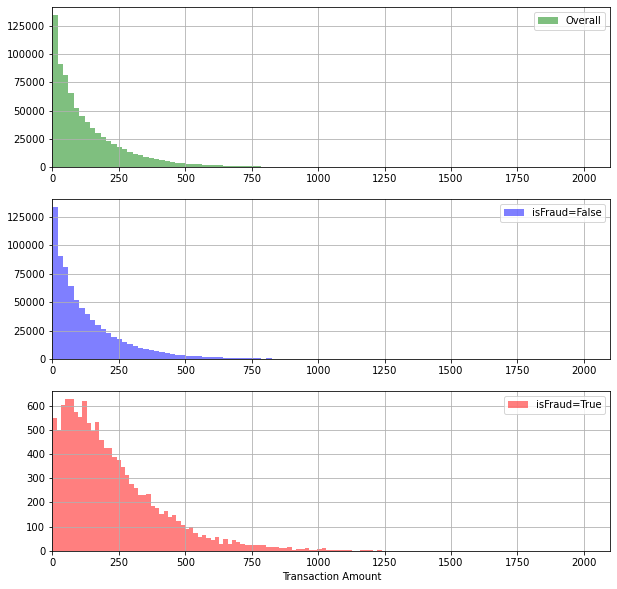

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

df['transactionAmount'].hist(alpha=0.5,color='green',
                             bins=100,label='Overall',
                             ax=axes[0])
axes[0].legend()
axes[0].set_xlim(0, 2100)
df[df['isFraud']==False]['transactionAmount'].hist(alpha=0.5,color='blue',
                                                   bins=100,label='isFraud=False',
                                                   ax=axes[1])
axes[1].legend()
axes[1].set_xlim(0, 2100)
df[df['isFraud']==True]['transactionAmount'].hist(alpha=0.5,color='red',
                                                  bins=100,label='isFraud=True',
                                                  ax=axes[2])
axes[2].legend()
axes[2].set_xlim(0, 2100)
plt.xlabel('Transaction Amount')


Since the distribution of transaction amount looks like a `lognormal` or `chi-squared` distribution, I mapped the data into a normal-shaped distribution below.  

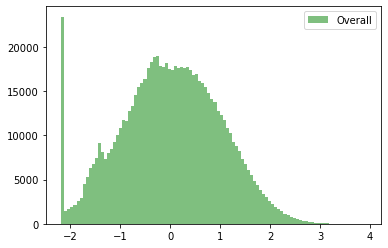

In [6]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)
x = pt.fit_transform(np.expand_dims(df['transactionAmount'], axis=1))
plt.hist(x, alpha=0.5, color='green', bins=100, label='Overall')
plt.legend()

## Imbalanced dataset

The transaction amounts for fraud and normal are hugely imbalanced. According to the statistics below, the percentage of fraudulent transactions in all transactions is only `1.58%`. I will use `Random Under Sampling` to solve this problem, which randomly chooses balanced data sizes for each class. 

The number of normal transactions is 773946 (98.42%);
The number of fraud transactions is 12417 (1.58%).


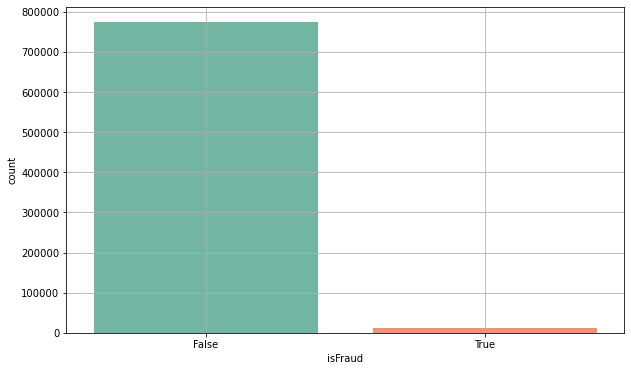

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(x='isFraud', data=df, palette='Set2')
plt.grid(True)
n_fraud = len(df[df['isFraud']==True])
n_normal = len(df[df['isFraud']==False])
print(f"The number of normal transactions is {n_normal} ({'{:.2f}%'.format(n_normal/len(df) * 100)});")
print(f"The number of fraud transactions is {n_fraud} ({'{:.2f}%'.format(n_fraud/len(df) * 100)}).")

This is an imbalanced dataset. It has a much larger sample size for isFraud=False than for isFraud=True.

## Credit limit vs transaction amount

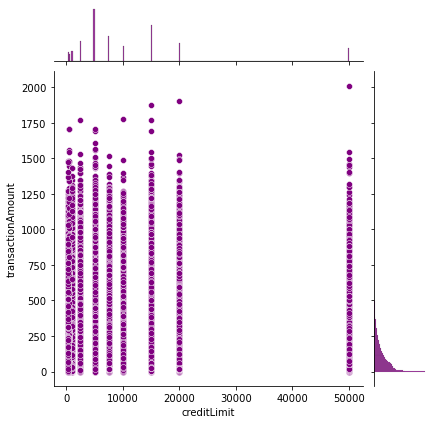

In [45]:
sns.jointplot(x='creditLimit', y='transactionAmount', data=df, color='purple')

## Available money vs transaction amount.

Hypothesis: more available money may induce larger transactions. 

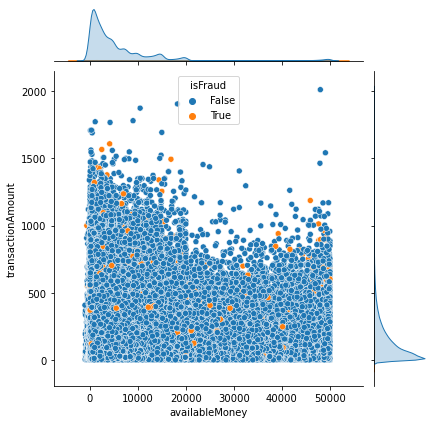

In [68]:
sns.jointplot(x='availableMoney', y='transactionAmount', data=df, color='purple', hue='isFraud')

This hypothesis is not supported by the data. There's not obvious trend for positive correlation. Daily expenses may be similar. 

## False CVV

Hypothesis: for fraudulent transactions, the percentage of mismatched enteredCVV and cardCVV is larger than normal transactions. 

To investigate more on this issue, I defined a `distance` between `cardCVV` and `enteredCVV`, which is in the range of `{0, 1, 2, 3}`, where `0` means they are perfectly matched, and `1` means they have `1` integer mismached. 

Under this `distance` measure, I found out that the larger the distance is, the more likely this transaction is a fraud. For example, analysis shows that the probability of a transaction being fraudulent when distance is 3, `3.53%` is more than twice of that when the distance is 0, `1.57%`.

In [7]:
def distance(a, b):
    if a == b:
        return 0
    ret = 0
    a, b = str(a), str(b)
    if len(b) < 3:
        b = 'a' * (3 - len(b)) + b
    for i in range(len(a)):
        if a[i] != b[i]:
            ret += 1
    return ret

df['falseCVVDigits'] = [distance(df['cardCVV'][i], df['enteredCVV'][i]) for i in range(len(df))]

Text(0.5, 0, 'False CVV Digits')

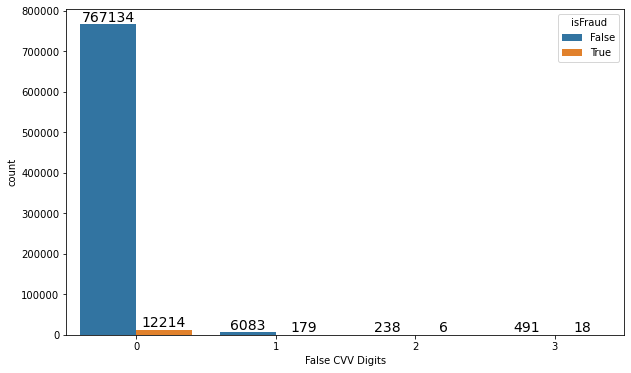

In [8]:
plt.figure(figsize=(10, 6))
vals = []
ax = sns.countplot(x='falseCVVDigits', data=df, hue='isFraud')
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 6700
    value = p.get_height()
    vals.append(value)
    ax.text(_x, _y, value, ha="center", fontsize=14)
plt.xlabel('False CVV Digits')

In [9]:
for i in range(4):
    print(f'The conditional probability of fraudulent transaction given {i} false entered CVV digits is {vals[i + 4] / (vals[i] + vals[i + 4])}')

The conditional probability of fraudulent transaction given 0 false entered CVV digits is 0.015672074605952668
The conditional probability of fraudulent transaction given 1 false entered CVV digits is 0.028585116576173745
The conditional probability of fraudulent transaction given 2 false entered CVV digits is 0.02459016393442623
The conditional probability of fraudulent transaction given 3 false entered CVV digits is 0.03536345776031434


On the other hand, for fraudulent transactions, the entered CVV is more likely to be wrong than for normal transactions (1.63% > 0.88%). 

In [10]:
df['correctCVV'] = df['cardCVV'] == df['enteredCVV']
df_fraud = df[df['isFraud']==True]
df_normal = df[df['isFraud']==False]

Percentage of false CVVs in fraud transactions is 1.63%
Percentage of false CVVs in normal transactions is 0.88%


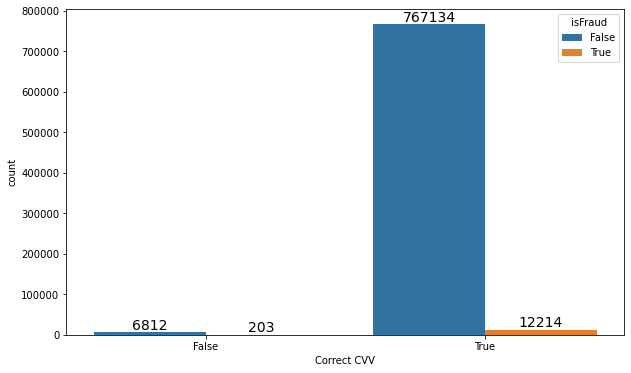

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='correctCVV', data=df, hue='isFraud')
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 6700
    value = p.get_height()
    ax.text(_x, _y, value, ha="center", fontsize=14)
plt.xlabel('Correct CVV')
n_false_fraud = np.sum(df_fraud['correctCVV']==False)
n_false_normal = np.sum(df_normal['correctCVV']==False)

print(f'Percentage of false CVVs in fraud transactions is {"{:.2f}%".format(n_false_fraud/len(df_fraud)*100)}')
print(f'Percentage of false CVVs in normal transactions is {"{:.2f}%".format(n_false_normal/len(df_normal)*100)}')


## Fraud Transactions by Transaction Type

Hypothesis: transaction for `address verification` is less likely to be fraudulent (`0.58%`) than other transaction types (`~1.6%`). 

[733898, 20064, 19984, 11963, 117, 337]
The conditional probability of fraudulent transaction given PURCHASE transaction is 0.01603918156332078
The conditional probability of fraudulent transaction given ADDRESS_VERIFICATION transaction is 0.005797532332391854
The conditional probability of fraudulent transaction given REVERSAL transaction is 0.016583829535948034


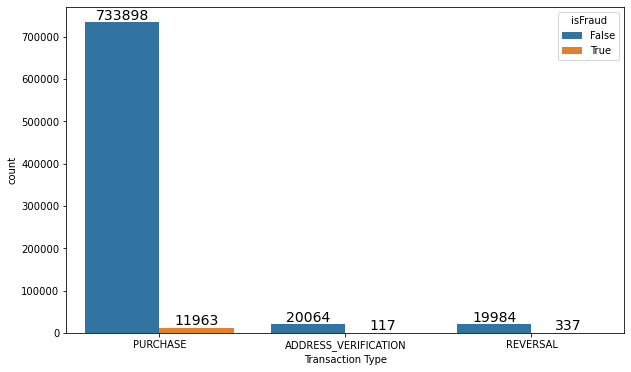

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='transactionType', data=df, hue='isFraud')
vals = []
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 6700
    value = p.get_height()
    vals.append(value)
    ax.text(_x, _y, value, ha="center", fontsize=14)
plt.xlabel('Transaction Type')

trans = ['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL']
print(vals)
for i in range(3):
    print(f'The conditional probability of fraudulent transaction given {trans[i]} transaction is {vals[i + 3] / (vals[i] + vals[i + 3])}')

## Fraud Transactions by Merchant

## Fraud Transactions by Country

In [133]:
set(df['acqCountry'])

{'CAN', 'MEX', 'PR', 'US'}

In [134]:
set(df['merchantCountryCode'])

{'CAN', 'MEX', 'PR', 'US'}

In [137]:
np.sum(df['acqCountry'] == df['merchantCountryCode'])

786218

In [138]:
len(df)

786363

In [143]:
missMatchCountry = df[df['acqCountry'] != df['merchantCountryCode']]
missMatchCountry.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,logTransactionAmount,correctCVV,datetime,timestamp,isMultiSwipe
523,984504651,984504651,50000,3680.02,2016-06-29T02:02:53,94.52,WSC #257352,US,PR,2,...,PURCHASE,46319.98,False,False,False,4.548811,True,2016-06-29 02:02:53,1467180173,False
5746,187912273,187912273,2500,1372.09,2016-01-27T14:58:05,134.69,Regal Cinemas #276341,US,CAN,2,...,PURCHASE,1127.91,True,False,False,4.902976,True,2016-01-27 14:58:05,1453924685,False
8487,205681025,205681025,15000,14570.84,2016-12-02T01:00:02,111.81,Lyft,MEX,US,2,...,PURCHASE,429.16,False,False,False,4.716801,True,2016-12-02 01:00:02,1480658402,False
9563,745217385,745217385,250,62.66,2016-02-26T02:07:20,113.48,Subway #44482,CAN,US,5,...,PURCHASE,187.34,True,False,False,4.731627,True,2016-02-26 02:07:20,1456470440,False
12629,593440936,593440936,500,88.32,2016-10-17T22:03:11,672.07,EZ Putt Putt #755869,CAN,US,5,...,PURCHASE,411.68,True,False,False,6.510363,True,2016-10-17 22:03:11,1476756191,False


In [142]:
print(np.sum(missMatchCountry['isFraud'] == True)/len(missMatchCountry))
print(np.sum(df['isFraud']==True) / len(df))


0.006896551724137931
0.01579041740264992


[766956, 2386, 3085, 1519, 12271, 55, 64, 27]
The conditional probability of fraudulent transaction given transaction in US is 0.015747657614533377
The conditional probability of fraudulent transaction given transaction in CAN is 0.022531749283080705
The conditional probability of fraudulent transaction given transaction in MEX is 0.020323912353127978
The conditional probability of fraudulent transaction given transaction in PR is 0.017464424320827943


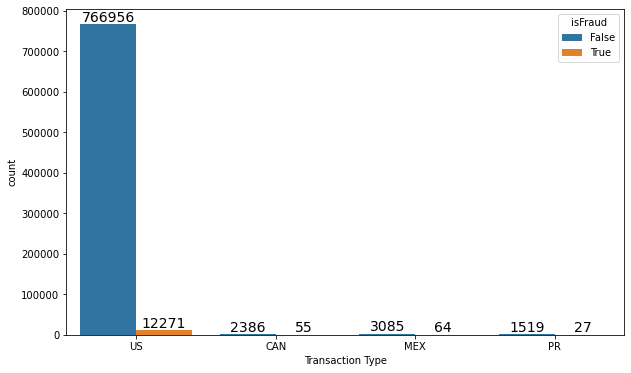

In [21]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='acqCountry', data=df, hue='isFraud')
vals = []
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 6700
    value = p.get_height()
    vals.append(value)
    ax.text(_x, _y, value, ha="center", fontsize=14)
plt.xlabel('Transaction Type')

trans = ['US', 'CAN', 'MEX', 'PR']
print(vals)
for i in range(4):
    print(f'The conditional probability of fraudulent transaction given transaction in {trans[i]} is {vals[i + 4] / (vals[i] + vals[i + 4])}')
    

## Fraud transactions vs account age 

In [29]:
from datetime import datetime
df['datetime'] = df['transactionDateTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
df['accountOpenDate'] = df['accountOpenDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['accountAge'] = df['datetime'] - df['accountOpenDate']
df['accountAge'] = df['accountAge'].apply(lambda x: x.days)

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


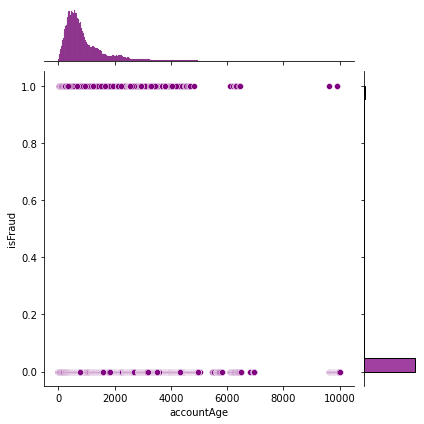

In [30]:
sns.jointplot(x='accountAge', y='isFraud', data=df, color='purple')

Text(0.5, 0, 'Account Age in Days')

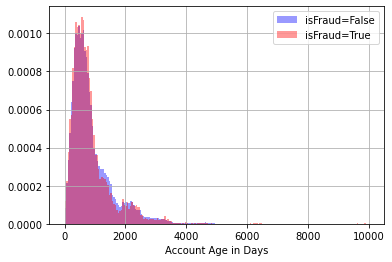

In [31]:
df[df['isFraud']==False]['accountAge'].hist(alpha=0.4,color='blue',
                                            bins=200,label='isFraud=False',
                                            density=True)
df[df['isFraud']==True]['accountAge'].hist(alpha=0.4,color='red',
                                            bins=200,label='isFraud=True',
                                            density=True)
plt.legend()
plt.xlabel("Account Age in Days")

# Question 3: Data Wrangling - Duplicate Transactions

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

Can you programmatically identify reversed and multi-swipe transactions?

What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)

Did you find anything interesting about either kind of transaction?

## Reversed transactions

In [84]:
df_reverse = df[df['transactionType']=='REVERSAL']
# print(df_reverse)
df_reverse.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,cardCVV,enteredCVV,cardLast4Digits,currentBalance,logTransactionAmount
count,2.032100e+04,2.032100e+04,20321.000000,20321.000000,20321.000000,20321.000000,20321.000000,20321.000000,20321.000000,20321.000000,20321.000000,2.032100e+04
mean,5.357861e+08,5.357861e+08,10889.941440,6067.844374,139.000886,8.900497,3.161213,544.541952,544.291127,4744.327937,4822.097066,-inf
std,2.550724e+08,2.550724e+08,11733.821694,8738.126015,147.876565,16.445404,9.223200,262.979824,262.911423,3010.835746,6581.493858,NaN
min,1.000881e+08,1.000881e+08,250.000000,-440.580000,0.000000,2.000000,1.000000,100.000000,30.000000,0.000000,0.000000,-inf
25%,3.288624e+08,3.288624e+08,5000.000000,1071.490000,33.440000,2.000000,1.000000,308.000000,308.000000,2174.000000,886.720000,3.509753e+00
50%,4.979417e+08,4.979417e+08,7500.000000,3017.250000,92.010000,5.000000,1.000000,537.000000,536.000000,4730.000000,2803.480000,4.521897e+00
75%,7.676200e+08,7.676200e+08,15000.000000,7304.880000,192.970000,9.000000,1.000000,787.000000,787.000000,7339.000000,5809.050000,5.262535e+00
max,9.992836e+08,9.992836e+08,50000.000000,50000.000000,1435.640000,90.000000,99.000000,998.000000,998.000000,9998.000000,47470.790000,7.269366e+00


In [103]:
df_reverse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20321 entries, 39 to 786301
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   accountNumber             20321 non-null  int64  
 1   customerId                20321 non-null  int64  
 2   creditLimit               20321 non-null  int64  
 3   availableMoney            20321 non-null  float64
 4   transactionDateTime       20321 non-null  object 
 5   transactionAmount         20321 non-null  float64
 6   merchantName              20321 non-null  object 
 7   acqCountry                20321 non-null  object 
 8   merchantCountryCode       20321 non-null  object 
 9   posEntryMode              20321 non-null  int64  
 10  posConditionCode          20321 non-null  int64  
 11  merchantCategoryCode      20321 non-null  object 
 12  currentExpDate            20321 non-null  object 
 13  accountOpenDate           20321 non-null  object 
 14  date

In [110]:
print(f'The total amount of reversed transactions is', '{:.2f}'.format(sum(df_reverse['transactionAmount'])))

The total amount of reversed transactions is 2824637.00


There are 20321 reversed transactions, with total amount of $2824637.00

## Multi-swipe transactions

In [95]:
from datetime import datetime

df['datetime'] = df['transactionDateTime'].apply(lambda dt: datetime.strptime(dt, '%Y-%m-%dT%H:%M:%S'))
df['timestamp'] = df['datetime'].apply(lambda x: int(datetime.timestamp(x)))
time_thred = 1 * 3600 # 1-hour threshold

multi_swipes = np.logical_and(df['transactionAmount'][1:] > 0, np.diff(df['transactionAmount']) == 0) # equal amount charges
multi_swipes = np.logical_and(multi_swipes, np.diff(df['timestamp']) < time_thred) # within time_thred

df_multi = df.iloc[np.where(multi_swipes)[0] + 1]

df_multi.head()
df_multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12887 entries, 39 to 786233
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   accountNumber             12887 non-null  int64         
 1   customerId                12887 non-null  int64         
 2   creditLimit               12887 non-null  int64         
 3   availableMoney            12887 non-null  float64       
 4   transactionDateTime       12887 non-null  object        
 5   transactionAmount         12887 non-null  float64       
 6   merchantName              12887 non-null  object        
 7   acqCountry                12887 non-null  object        
 8   merchantCountryCode       12887 non-null  object        
 9   posEntryMode              12887 non-null  int64         
 10  posConditionCode          12887 non-null  int64         
 11  merchantCategoryCode      12887 non-null  object        
 12  currentExpDate  

In [96]:
df_multi.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,logTransactionAmount,correctCVV,datetime,timestamp
39,574788567,574788567,2500,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,9,...,8522,REVERSAL,299.02,True,False,False,5.371242,True,2016-05-24 01:38:03,1464068283
133,984504651,984504651,50000,46367.41,2016-01-16T09:53:15,450.74,Planet Fitness #849960,US,US,5,...,8332,REVERSAL,3632.59,False,False,False,6.110891,True,2016-01-16 09:53:15,1452955995
200,984504651,984504651,50000,36452.49,2016-02-12T05:10:49,34.92,Golds Gym #747443,US,US,9,...,8332,REVERSAL,13547.51,False,False,False,3.553060,True,2016-02-12 05:10:49,1455271849
263,984504651,984504651,50000,26680.99,2016-03-12T06:34:29,118.52,AMC #706324,US,US,2,...,8332,PURCHASE,23319.01,True,False,False,4.775082,True,2016-03-12 06:34:29,1457782469
264,984504651,984504651,50000,26562.47,2016-03-12T06:36:41,118.52,AMC #706324,US,US,2,...,8332,PURCHASE,23437.53,True,False,False,4.775082,True,2016-03-12 06:36:41,1457782601


In [99]:
df.iloc[38:40]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,logTransactionAmount,correctCVV,datetime,timestamp
38,574788567,574788567,2500,2416.11,2016-05-24T01:35:33,215.13,Convenient Tire,US,US,9,...,8522,PURCHASE,83.89,True,False,False,5.371242,True,2016-05-24 01:35:33,1464068133
39,574788567,574788567,2500,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,9,...,8522,REVERSAL,299.02,True,False,False,5.371242,True,2016-05-24 01:38:03,1464068283


In [100]:
df['isMultiSwipe'] = [False] + list(multi_swipes)

In [102]:
np.sum(df['isMultiSwipe']==True)

12887

In [112]:
print(f'The total amount of multi-swipe transaction is', '{:.2f}'.format(sum(df_multi['transactionAmount'])))

The total amount of multi-swipe transaction is 1917610.16


When the time period is set to be 1-hour, the results show there's `12887` records of multi-swipe transactions, with total amount of `$1917610.16`. The column `isMultiSwipe` is boolean which indicates whether a record is a multi-swipe transaction. 

## Duplicate transactions vs Fraud transactions

In real life, when customers saw duplicate transactions on the bank activity logs, they probably will report a fraud. Therefore, here I propose a hypothesis that the fraudulent transaction rate is higher in duplicate transactions than in normal transactinos. 

### Reversed vs Fraud

Percentage of reversed in fraud transactions is 2.71%
Percentage of reversed in normal transactions is 2.58%
Probability of fraud given this transaction is reversed is that 0.016583829535948034
Probability of fraud given this transaction is not reversed is that 0.015769370347839935


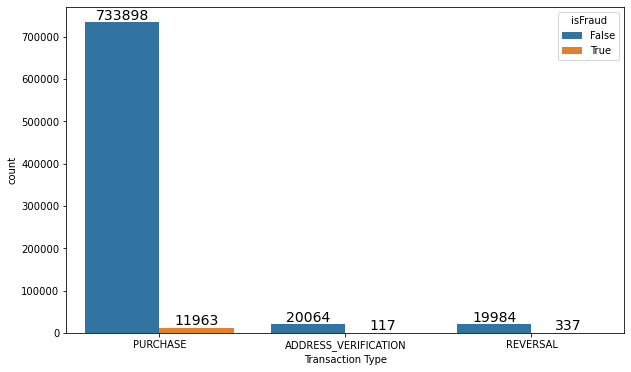

In [130]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='transactionType', data=df, hue='isFraud')
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 6700
    value = p.get_height()
    ax.text(_x, _y, value, ha="center", fontsize=14)
plt.xlabel('Transaction Type')
# n_correct_fraud = np.sum(df_fraud['correctCVV']==True)
n_rev_fraud = np.sum(np.logical_and(df['transactionType']=='REVERSAL', df['isFraud']==True))
n_rev_normal = np.sum(np.logical_and(df['transactionType']=='REVERSAL', df['isFraud']==False))

n_nrev_fraud = np.sum(np.logical_and(df['transactionType']!='REVERSAL', df['isFraud']==True))
n_nrev = np.sum(df['transactionType']!='REVERSAL')

print(f'Percentage of reversed in fraud transactions is {"{:.2f}%".format(n_rev_fraud/len(df_fraud)*100)}')
print(f'Percentage of reversed in normal transactions is {"{:.2f}%".format(n_rev_normal/len(df_normal)*100)}')
print(f'Probability of fraud given this transaction is reversed is that {n_rev_fraud / (n_rev_fraud + n_rev_normal)}')
print(f'Probability of fraud given this transaction is not reversed is that {n_nrev_fraud / n_nrev}')


The results show a slight higher fraud rate for a transaction that is reversed than non-reversed. 

### Multi-Swipe vs Fraud Transactions

Percentage of multi-swipe in fraud transactions is 1.83%
Percentage of multi-swipe in normal transactions is 1.64%
Probability of fraud given this transaction is multi-swipe is that 0.017614650422906806
Probability of fraud given this transaction is not multi-swipe is that 0.01576002358185645


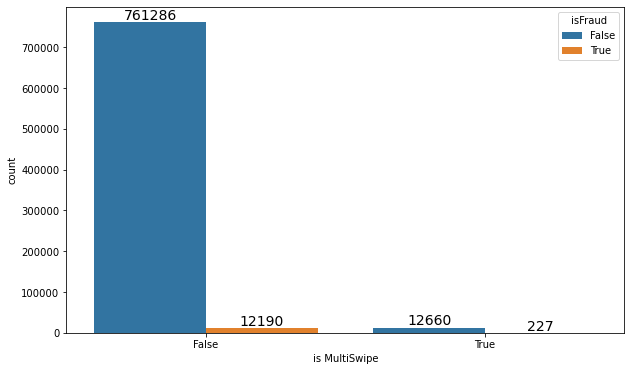

In [129]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='isMultiSwipe', data=df, hue='isFraud')
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 6700
    value = p.get_height()
    ax.text(_x, _y, value, ha="center", fontsize=14)
plt.xlabel('is MultiSwipe')
# n_correct_fraud = np.sum(df_fraud['correctCVV']==True)
n_multi_fraud = np.sum(np.logical_and(df['isMultiSwipe']==True, df['isFraud']==True))
n_multi_normal = np.sum(np.logical_and(df['isMultiSwipe']==True, df['isFraud']==False))

n_nmulti_fraud = np.sum(np.logical_and(df['isMultiSwipe']==False, df['isFraud']==True))
n_nmulti = np.sum(df['isMultiSwipe']==False)

print(f'Percentage of multi-swipe in fraud transactions is {"{:.2f}%".format(n_multi_fraud/len(df_fraud)*100)}')
print(f'Percentage of multi-swipe in normal transactions is {"{:.2f}%".format(n_multi_normal/len(df_normal)*100)}')
print(f'Probability of fraud given this transaction is multi-swipe is that {n_multi_fraud / (n_multi_fraud + n_multi_normal)}')
print(f'Probability of fraud given this transaction is not multi-swipe is that {n_nmulti_fraud / n_nmulti}')


The results show a slightly higher fraudulent rate for a transaction that is multi-swipe than non-multi-swipe. 

In [186]:
df.to_csv('transactions_eda.csv', index=False)